# Age Prediction from Facial Images
## This notebook fine-tunes pre-trained ResNet-18 model for age prediction using facial image datasets from UTKFace

In [24]:
from fastai.vision.all import *
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import tarfile
import random
import torch
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

## Data Loading and Preprocessing

In [ ]:
# UTKFace Dataset
image_dir = '/kaggle/input/utk-face-cropped/utkcropped'
all_filenames = os.listdir(image_dir)

ages = []
genders = []
races = []
file_paths = []

gender_map = {0: 'Male', 1: 'Female'}
race_map = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Other'}

# Regex pattern to capture the age, gender, and race from the filename
pattern = re.compile(r'(\d+)_(\d+)_(\d+)_.*')

for filename in all_filenames:
    match = pattern.match(filename)
    if match:
        try:
            # Extract and convert all parts first
            age = int(match.group(1))
            gender = int(match.group(2))
            race = int(match.group(3))
            
            ages.append(age)
            genders.append(gender)
            races.append(race)
            file_paths.append(os.path.join(image_dir, filename))
            
        except (ValueError, IndexError):
            pass
            #print(f"Warning: Could not parse data from filename '{filename}'. Skipping.")
    else:
        pass
        #print(f"Warning: Filename '{filename}' did not match the expected pattern. Skipping.")


# Create the DataFrame
df_utk = pd.DataFrame({
    'age': ages,
    'gender': genders,
    'race': races,
    'file_path': file_paths
})

df_utk['gender_label'] = df_utk['gender'].map(gender_map)
df_utk['race_label'] = df_utk['race'].map(race_map)


# Filter out over 90 year old
df_filtered = df_utk[df_utk['age'] <= 90].reset_index(drop=True)

# Take max 200 individual sample of each age group
df_subset = df_filtered.groupby('age').head(200).reset_index(drop=True)

print(f"Original DataFrame size: {len(df_utk)}")
print(f"Sampled DataFrame size: {len(df_subset)}")

df_utk.head(1)

Original DataFrame size: 23705
Sampled DataFrame size: 12776


,age,gender,race,file_path,gender_label,race_label
0,26,0,2,/kaggle/input/utk-face-cropped/utkcropped/26_0_2_20170104023102422.jpg.chip.jpg,Male,Asian


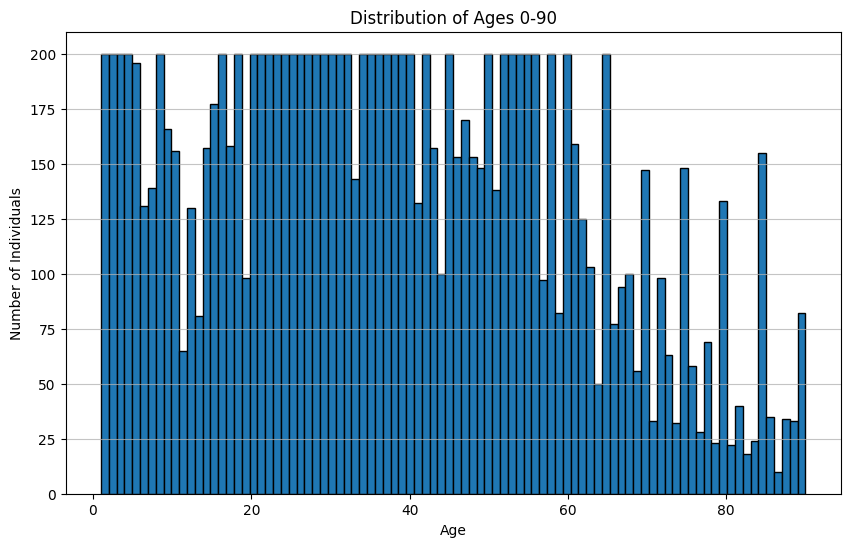

In [9]:
plt.figure(figsize=(10, 6))
df_subset['age'].plot(kind='hist', bins=90, edgecolor='black') 
plt.title('Distribution of Ages 0-90')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Model Training

In [10]:
datablock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('file_path'),
    get_y=ColReader('age'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    n_inp=1 
)
dls = datablock.dataloaders(df_subset, bs=64)

Displaying a batch from DataLoaders


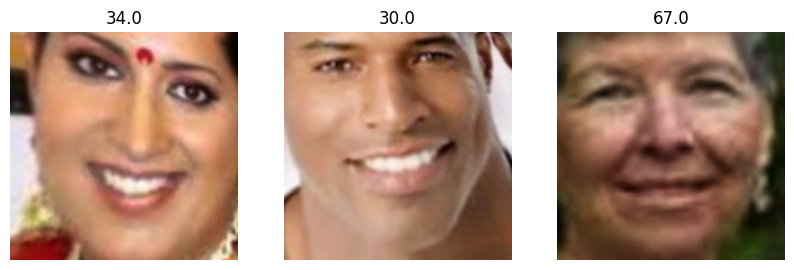

In [11]:
print("Displaying a batch from DataLoaders")
dls.show_batch(max_n=3, figsize=(10,10))
plt.show()

In [13]:
learn_18 = vision_learner(dls, resnet18, y_range=(0,95), loss_func=MSELossFlat(), metrics=mae)
learn_18.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


epoch,train_loss,valid_loss,mae,time
0,779.614441,564.973572,18.964527,00:35


epoch,train_loss,valid_loss,mae,time
0,444.960236,250.876541,12.237324,00:28
1,273.515594,167.343491,10.065807,00:27
2,164.816284,119.655663,8.443293,00:26
3,124.455750,106.784439,7.853744,00:26
4,101.075851,106.420158,7.946301,00:26
5,91.036003,86.631645,7.116892,00:26
6,80.254662,74.704269,6.473388,00:26
7,69.599388,73.749123,6.468338,00:26
8,62.732235,69.857048,6.300384,00:26
9,61.640232,71.049057,6.363594,00:26


In [14]:
learn_18.export('model_18.pkl')

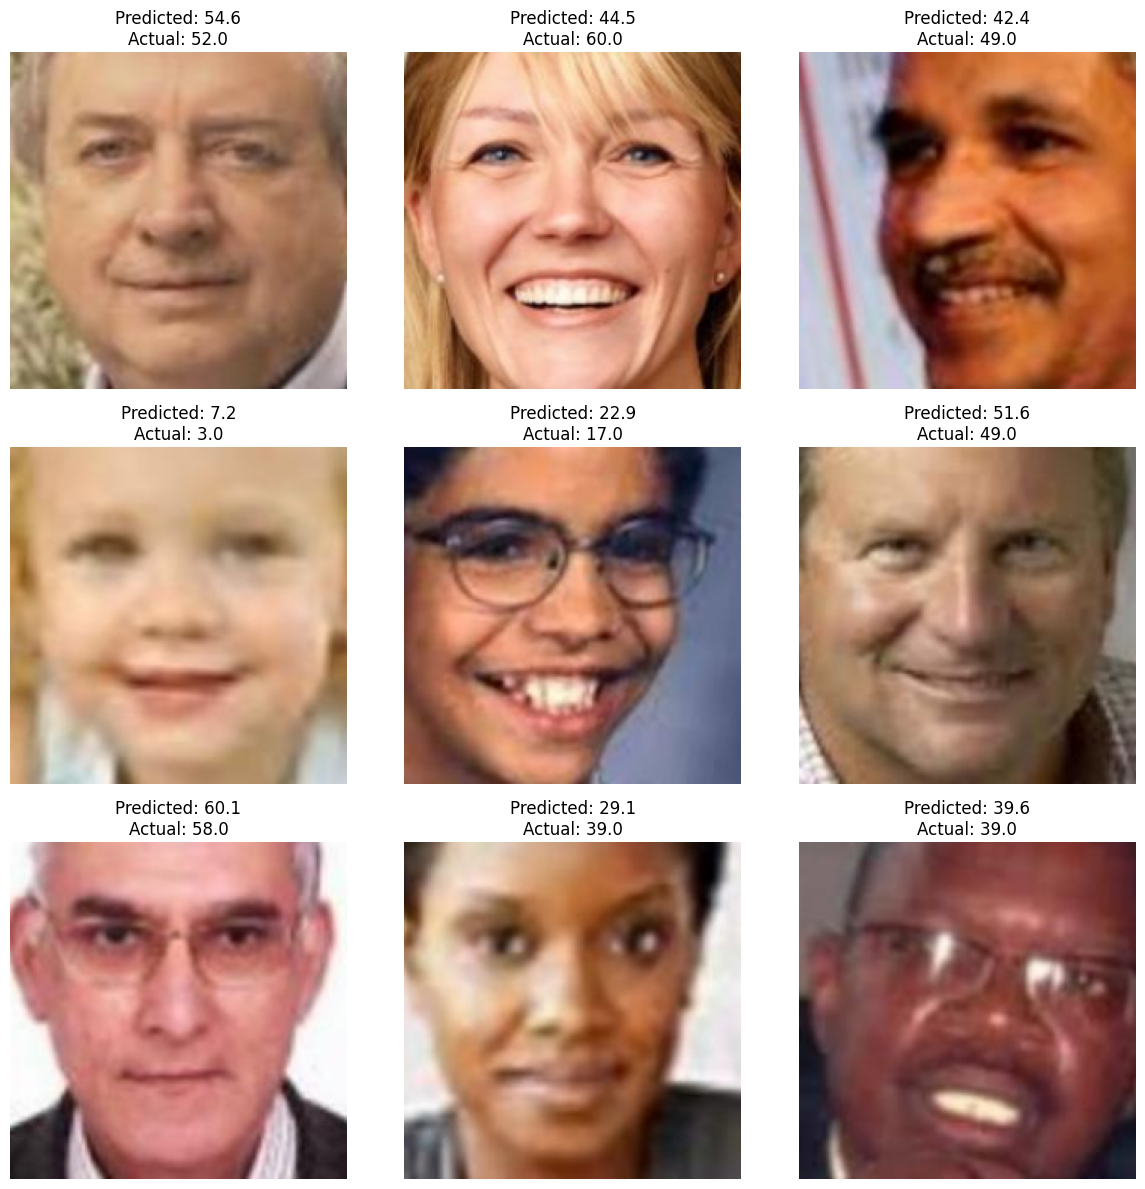

In [28]:
# Display batch with predicted and real age
x, y = dls.valid.one_batch()

with torch.no_grad():
    preds = learn_18.model(x).cpu()

n_images = min(9, len(x)) 
nrows = int(n_images**0.5)
ncols = (n_images + nrows - 1) // nrows
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))

for i, ax in enumerate(axs.flat):
    if i >= n_images:
        ax.axis('off')
        continue
    
    decoded_img_tuple = dls.decode((x[i], y[i]))
    img_to_show = decoded_img_tuple[0][0].permute(1, 2, 0)
    
    ax.imshow(img_to_show)
    
    actual_age = y[i].item()
    predicted_age = preds[i].item()
    
    ax.set_title(f"Predicted: {predicted_age:.1f}\nActual: {actual_age:.1f}")
    ax.axis('off')

plt.tight_layout()
plt.show()